In [327]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
#os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)
import warnings
warnings.simplefilter(action='ignore')
import fbprophet
import pmdarima as pm

In [328]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [329]:
covid = pd.read_csv('./COVID-19 di Indonesia @kawalcovid19 - Statistik Harian.csv')
covid.head()

,Unnamed: 0,Kasus harian,Kasus Impor,Kasus Lokal,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),...,Positif DKI,Unnamed: 76,Pos Rate DKI,Pos Rate DKI - 7 harian,NON DKI,Positif Non DKI,Unnamed: 81,Pos Rate Non DKI,Pos Rate Non DKI - 7 harian,CFR
0,3/2/2020,2,0.0,2.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3/3/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/4/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3/5/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3/6/2020,2,0.0,2.0,4,4,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [330]:
covid.columns


Index(['Unnamed: 0', 'Kasus harian', 'Kasus Impor', 'Kasus Lokal',
       'Total kasus', 'Kasus aktif', '% kasus aktif', 'Sembuh\n(baru)',
       'Sembuh', 'Tingkat kesembuhan (seluruh kasus)',
       'Tingkat kesembuhan (closed cases)', 'Meninggal\n(baru)',
       'Meninggal\nDunia', 'Tingkat kematian (seluruh kasus)',
       'Tingkat kematian (closed cases)', 'PDP', 'ODP', 'Suspek aktif',
       'Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
       'Negatif', 'Positif \n(=C)', 'Dalam Proses', 'Spesimen',
       'Spesimen (PCR-TCM)', 'Spesimen (Antigen)', 'Orang yang dites',
       'Orang yang dites (PCR-TCM)', 'Orang yang dites (Antigen)',
       'Vaksinasi (ineligible)', 'Jumlah test/juta penduduk', 'Test/Positif',
       'Jumlah org yg dites / positif', 'Jumlah Test/Positif harian',
       'Positif / Jumlah Tes', 'Positive rate harian', 'Case Growth Rate',
       'Tingkat positivitas mingguan',
       'Jumlah spesimen diperiksa (rata-rata 7 hari)',
       'Ju

In [331]:
columns_ = ['Kasus aktif']
df=covid[columns_]
df.dropna(inplace=True)

In [332]:
df

,Kasus aktif
0,2
1,2
2,2
3,2
4,4
...,...
577,"34,867"
578,"33,812"
579,"32,876"
580,"31,054"


In [333]:
df[df.index>=200]

,Kasus aktif
200,"56,889"
201,"57,796"
202,"58,378"
203,"58,788"
204,"59,453"
...,...
577,"34,867"
578,"33,812"
579,"32,876"
580,"31,054"


## Data Wrangling

In [334]:
index = pd.date_range('3/3/2020', periods=582, freq='D') #create new index with assigning timedate on it
df.index = index
df

,Kasus aktif
2020-03-03,2
2020-03-04,2
2020-03-05,2
2020-03-06,2
2020-03-07,4
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [335]:
#df['Date'] = df.index

In [336]:
a = df[df.index>='3/12/2020'] #drop the early date as there are missing data
a

,Kasus aktif
2020-03-12,27
2020-03-13,60
2020-03-14,83
2020-03-15,104
2020-03-16,121
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [337]:
df_ = a.copy()
df1 = df_.copy()
df1

,Kasus aktif
2020-03-12,27
2020-03-13,60
2020-03-14,83
2020-03-15,104
2020-03-16,121
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [338]:
df1.dtypes

Kasus aktif    object
dtype: object

In [339]:
df1['Kasus aktif'] = df1['Kasus aktif'].replace(',','', regex=True) #remove comma 
df1['Kasus aktif'] = df1['Kasus aktif'].apply(pd.to_numeric,errors='coerce') #change object into numeric
df1.dtypes

Kasus aktif    int64
dtype: object

In [340]:
#Check data accountability

#1. Data Duplicate
print('Number of duplicated data: ', df1.duplicated().sum())

#2. Missing Data
print('Number of missing (NaN/null) data: ', df1.isnull().sum())

#3. Number of date range
print('Discrepancy of actual date range with dataset: ', len(df1) - len(df1.index.unique()))

Number of duplicated data:  1
Number of missing (NaN/null) data:  Kasus aktif    0
dtype: int64
Discrepancy of actual date range with dataset:  0


In [341]:
df1[df1.duplicated()]

,Kasus aktif
2020-11-02,55792


In [342]:
df1[df1.index>='11/1/2020']
#seeing no strange duplicated data, we move on

,Kasus aktif
2020-11-01,56899
2020-11-02,55792
2020-11-03,54732
2020-11-04,54190
2020-11-05,54306
...,...
2021-10-01,34867
2021-10-02,33812
2021-10-03,32876
2021-10-04,31054


## EDA

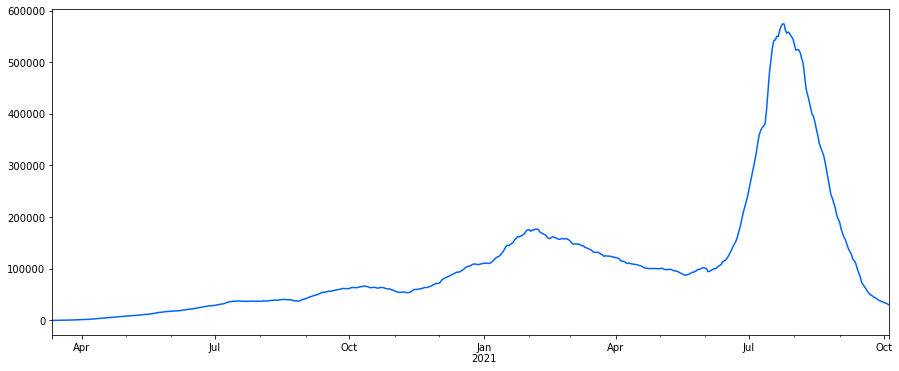

In [343]:
#Plot the sequence data 

df1['Kasus aktif'].plot(figsize=(15, 6))

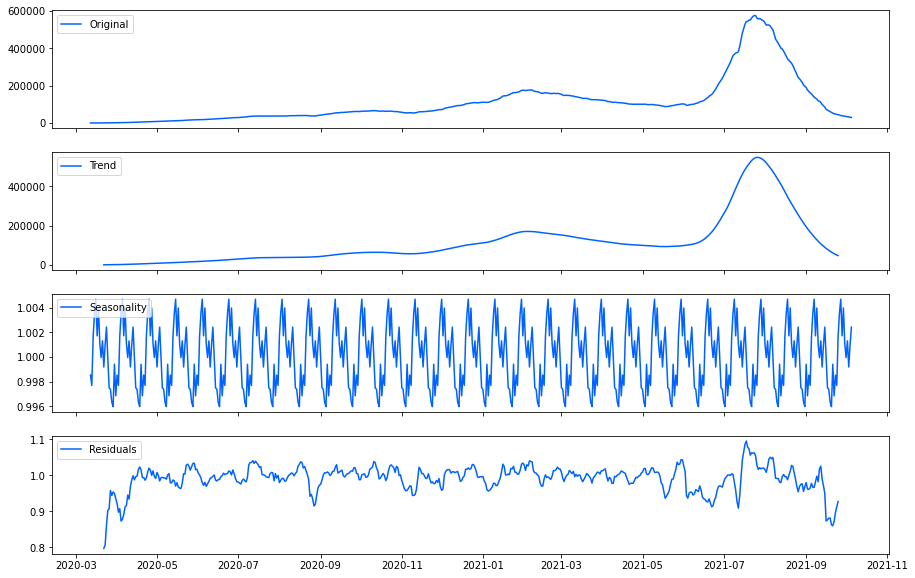

In [344]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=df1, model='mul', period=20)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

fig, axes = plt.subplots(4,1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df1, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [345]:
# resample to annual and plot each
monthly_cases = df1.resample('M').mean()
#monthly_cases.plot(figsize=[14,4])
monthly_cases

,Kasus aktif
2020-03-31,514.500000
2020-04-30,4426.200000
2020-05-31,12435.516129
2020-06-30,22786.866667
2020-07-31,35358.129032
2020-08-31,38906.580645
2020-09-30,54175.833333
2020-10-31,63221.806452
2020-11-30,60277.233333
2020-12-31,95449.580645


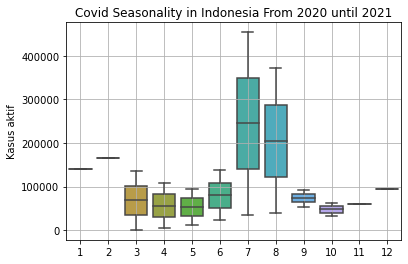

In [346]:
# boxplot of mean cases of months to determine variance and range
sns.boxplot(x=monthly_cases.index.month, y=monthly_cases['Kasus aktif'])
plt.title('Covid Seasonality in Indonesia From 2020 until 2021')
plt.grid(b=True); #GRID is to create rectangular block format


We can see there's seasonality within 2 years, whereas July and August is the worst month throughout years. 

## Quick Start with FB Prophet

In [347]:
df1.reset_index(inplace=True)
df1.rename(columns={'Kasus aktif':'y'}, inplace=True)
df1.rename(columns={'index':'ds'}, inplace=True)
df1

,ds,y
0,2020-03-12,27
1,2020-03-13,60
2,2020-03-14,83
3,2020-03-15,104
4,2020-03-16,121
...,...,...
568,2021-10-01,34867
569,2021-10-02,33812
570,2021-10-03,32876
571,2021-10-04,31054


In [348]:
df1.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [349]:
# Python

from fbprophet import Prophet
m = Prophet()
m.fit(df1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [350]:
future = m.make_future_dataframe(periods=180)
print(future.head())
print(future.tail())

          ds
0 2020-03-12
1 2020-03-13
2 2020-03-14
3 2020-03-15
4 2020-03-16
            ds
748 2022-03-30
749 2022-03-31
750 2022-04-01
751 2022-04-02
752 2022-04-03


In [351]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
748,2022-03-30,346107.379546,226416.082684,464821.187535
749,2022-03-31,346934.218143,232703.292764,477505.402553
750,2022-04-01,347420.394136,238898.614301,479281.710656
751,2022-04-02,348017.990270,228989.921734,463290.336454
752,2022-04-03,347871.379838,230541.948212,468392.235023


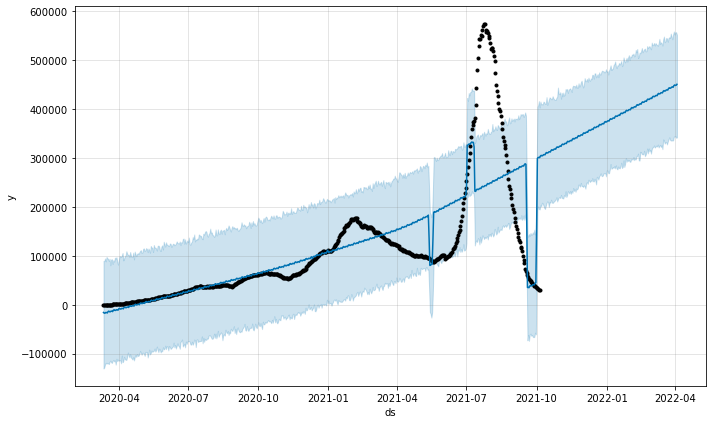

In [397]:
m.plot(forecast);

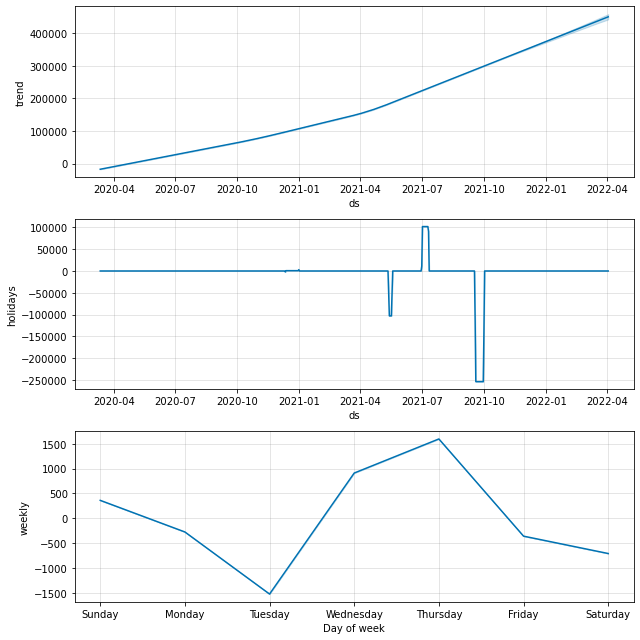

In [398]:
m.plot_components(forecast);

In [354]:
!pip install holidays

In [376]:
# add holidays 
school = pd.DataFrame({
  'holiday': 'school',
  'ds': pd.date_range('7/1/2021', periods=10, freq='D'),   
    
  'lower_window': 0, # these help us specify spillover into previous and future days which will be treated as own holidays
  'upper_window': 1,})


ied = pd.DataFrame({
  'holiday': 'ied',
  'ds': pd.date_range('5/13/2021', periods=5, freq='D'),   
    
  'lower_window': 0, # these help us specify spillover into previous and future days which will be treated as own holidays
  'upper_window': 1,})

christmasNY2020 = pd.DataFrame({
  'holiday': 'christmastNY2020',
  'ds': pd.date_range('12/11/2020', periods=20, freq='D'),
  'lower_window': 0,
  'upper_window': 1,})

PPKM = pd.DataFrame({
  'holiday': 'PPKM',
  'ds': pd.date_range('09/18/2021', periods=13, freq='D'),
  'lower_window': 0,
  'upper_window': 1,})

christmasNY2021 = pd.DataFrame({
  'holiday': 'christmastNY2021',
  'ds': pd.date_range('12/18/2021', periods=13, freq='D'),
  'lower_window': 0,
  'upper_window': 1,
    

})

holidays = pd.concat((school, christmasNY2020, christmasNY2021, PPKM, ied))

In [377]:
holidays.holiday.value_counts()


christmastNY2020    20
christmastNY2021    13
PPKM                13
school              10
ied                  5
Name: holiday, dtype: int64

In [378]:
holidays.head()

,holiday,ds,lower_window,upper_window
0,school,2021-07-01,0,1
1,school,2021-07-02,0,1
2,school,2021-07-03,0,1
3,school,2021-07-04,0,1
4,school,2021-07-05,0,1


In [379]:
# fit and predict
m = Prophet(holidays=holidays)
forecast = m.fit(df1).predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [380]:
# we can see the effects of various 'holidays' on site visits
forecast[(forecast['ied'] + forecast['school'] + forecast['christmastNY2020'] + forecast['christmastNY2021']).abs() > 0][
        ['ds', 'ied', 'school','christmastNY2021', 'christmastNY2020']][-10:]

,ds,ied,school,christmastNY2021,christmastNY2020
477,2021-07-02,0.0,101983.463811,0.0,0.0
478,2021-07-03,0.0,101983.463811,0.0,0.0
479,2021-07-04,0.0,101983.463811,0.0,0.0
480,2021-07-05,0.0,101983.463811,0.0,0.0
481,2021-07-06,0.0,101983.463811,0.0,0.0
482,2021-07-07,0.0,101983.463811,0.0,0.0
483,2021-07-08,0.0,101983.463811,0.0,0.0
484,2021-07-09,0.0,101983.463811,0.0,0.0
485,2021-07-10,0.0,101983.463811,0.0,0.0
486,2021-07-11,0.0,90764.927373,0.0,0.0


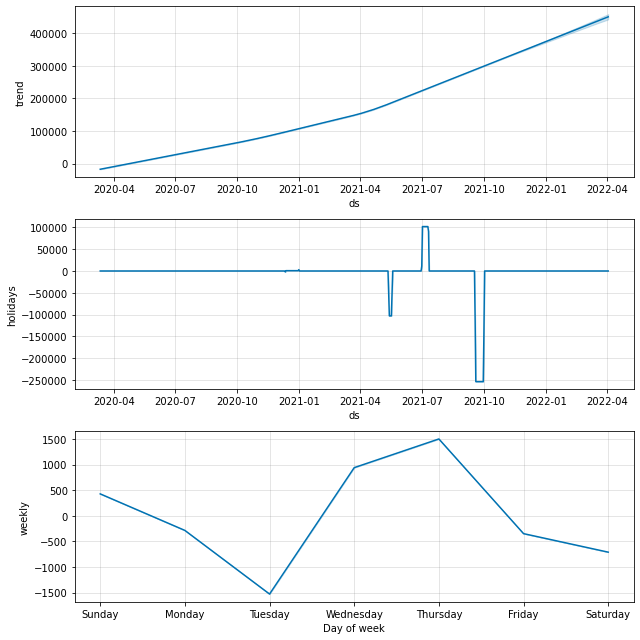

In [381]:
# check the impacts visually
m.plot_components(forecast);

In [382]:
# Add in another seasonality besides yearly, weekly, daily
# fit model
m = Prophet(holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [383]:
fcst_month = m.predict(future)

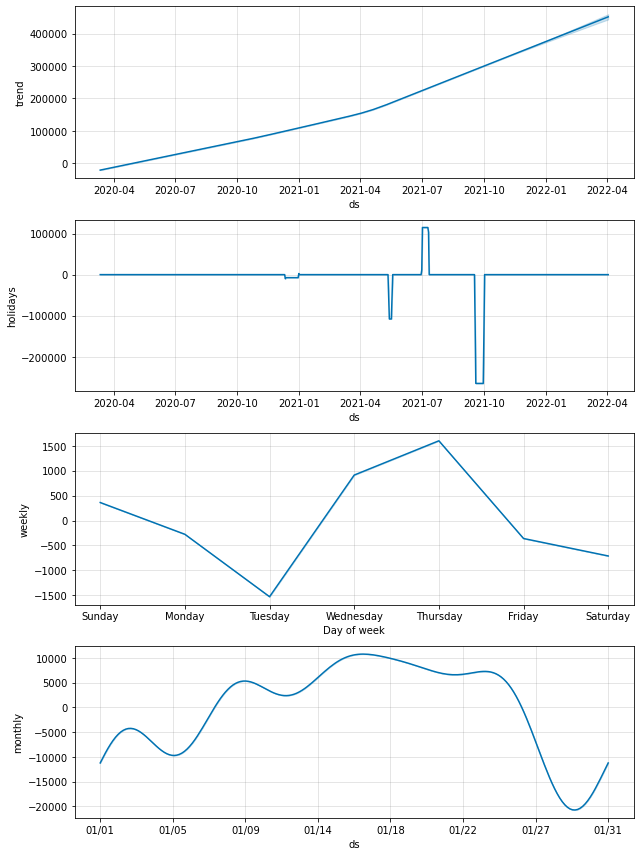

In [384]:
m.plot_components(fcst_month)
plt.show()

In [395]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
158,176 days,5.383160e+09,73370.018214,55564.036301,0.346977,0.211054,0.380952
159,177 days,5.442359e+09,73772.348882,55722.503710,0.353991,0.212907,0.404762
160,178 days,5.515696e+09,74267.734818,55986.405452,0.363126,0.214708,0.428571
161,179 days,5.603946e+09,74859.506145,56378.158709,0.374277,0.221069,0.444444
162,180 days,5.723257e+09,75652.212648,57003.514179,0.387475,0.228804,0.460317


In [391]:
from fbprophet.diagnostics import cross_validation
#Starting from 730 days in, making a prediction every 180 days, 365 days into the future
df_cv = cross_validation(m, initial='200 days', period='30 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-10-10 00:00:00 and 2021-04-08 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-10-11,69824.259499,68679.951051,71074.097593,66578,2020-10-10
1,2020-10-12,70512.801187,69369.758702,71803.238097,66262,2020-10-10
2,2020-10-13,71212.250515,69949.751736,72370.010778,65299,2020-10-10
3,2020-10-14,71861.590711,70679.699821,73031.094942,64742,2020-10-10
4,2020-10-15,72570.930302,71349.664490,73846.038833,63231,2020-10-10


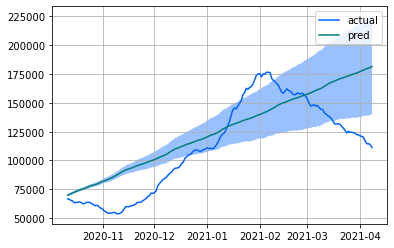

In [392]:
# Cross validation result. 

#Just looking at data from first cutoff
first_cut = df_cv[df_cv.cutoff == datetime(2020,10,10)]
plt.plot(first_cut.ds,first_cut.y,label='actual')
plt.plot(first_cut.ds,first_cut.yhat,label = 'pred')
plt.fill_between(first_cut.ds,first_cut.yhat_lower,first_cut.yhat_upper,alpha=0.4)
plt.grid()
plt.legend()

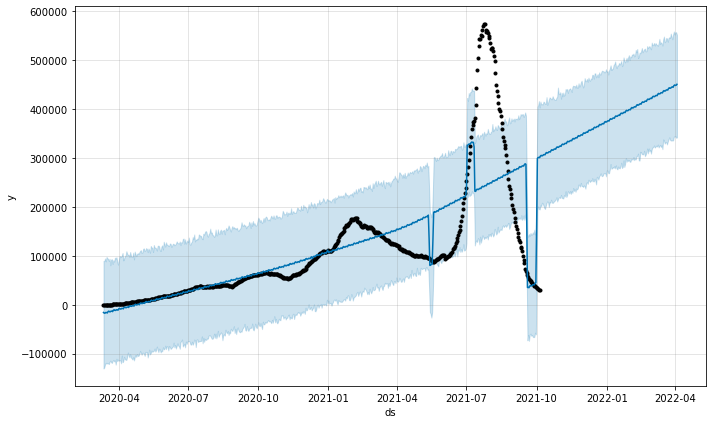

In [394]:
m.plot(forecast);